Dataset: https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset?select=csv


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Cramers V
from scipy.stats import chi2_contingency

# Splitting the data
from sklearn.model_selection import train_test_split

# Classification Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Scoring Functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# suppressing warnings
import warnings
warnings.filterwarnings('ignore')

## Preparing and Exploring the Data

In [2]:
df_mass_test = pd.read_csv("data/mass_case_description_test_set.csv", low_memory=True)
df_mass_train = pd.read_csv("data/mass_case_description_train_set.csv", low_memory=True)

In [3]:
# Combine the datasets ensuring that all columns match
assert list(df_mass_test.columns) == list(df_mass_train.columns), "Columns aren't the same"
df = pd.concat([df_mass_test, df_mass_train], ignore_index=True)
df

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,P_02033,2,RIGHT,MLO,1,mass,IRREGULAR,ILL_DEFINED,3,MALIGNANT,4,Mass-Training_P_02033_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_02033_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_02033_RIGHT_MLO_1/1.3.6.1.4.1....
1692,P_02079,2,RIGHT,CC,1,mass,ROUND,SPICULATED,3,MALIGNANT,5,Mass-Training_P_02079_RIGHT_CC/1.3.6.1.4.1.959...,Mass-Training_P_02079_RIGHT_CC_1/1.3.6.1.4.1.9...,Mass-Training_P_02079_RIGHT_CC_1/1.3.6.1.4.1.9...
1693,P_02079,2,RIGHT,MLO,1,mass,ROUND,SPICULATED,3,MALIGNANT,5,Mass-Training_P_02079_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_02079_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_02079_RIGHT_MLO_1/1.3.6.1.4.1....
1694,P_02092,2,LEFT,CC,1,mass,IRREGULAR,SPICULATED,3,MALIGNANT,2,Mass-Training_P_02092_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_02092_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_02092_LEFT_CC_1/1.3.6.1.4.1.95...


In [4]:
# Create a new column that is true whenever there is a malignant tumor.
# This will be what the model attempts to predict.

df = df[df['pathology'].isin(["MALIGNANT", "BENIGN"])]
classification = df['pathology'] == 'MALIGNANT'
df = df.assign(isCancer = classification)
df

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,isCancer
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,True
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,True
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,True
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,True
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,P_02033,2,RIGHT,MLO,1,mass,IRREGULAR,ILL_DEFINED,3,MALIGNANT,4,Mass-Training_P_02033_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_02033_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_02033_RIGHT_MLO_1/1.3.6.1.4.1....,True
1692,P_02079,2,RIGHT,CC,1,mass,ROUND,SPICULATED,3,MALIGNANT,5,Mass-Training_P_02079_RIGHT_CC/1.3.6.1.4.1.959...,Mass-Training_P_02079_RIGHT_CC_1/1.3.6.1.4.1.9...,Mass-Training_P_02079_RIGHT_CC_1/1.3.6.1.4.1.9...,True
1693,P_02079,2,RIGHT,MLO,1,mass,ROUND,SPICULATED,3,MALIGNANT,5,Mass-Training_P_02079_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_02079_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_02079_RIGHT_MLO_1/1.3.6.1.4.1....,True
1694,P_02092,2,LEFT,CC,1,mass,IRREGULAR,SPICULATED,3,MALIGNANT,2,Mass-Training_P_02092_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_02092_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_02092_LEFT_CC_1/1.3.6.1.4.1.95...,True


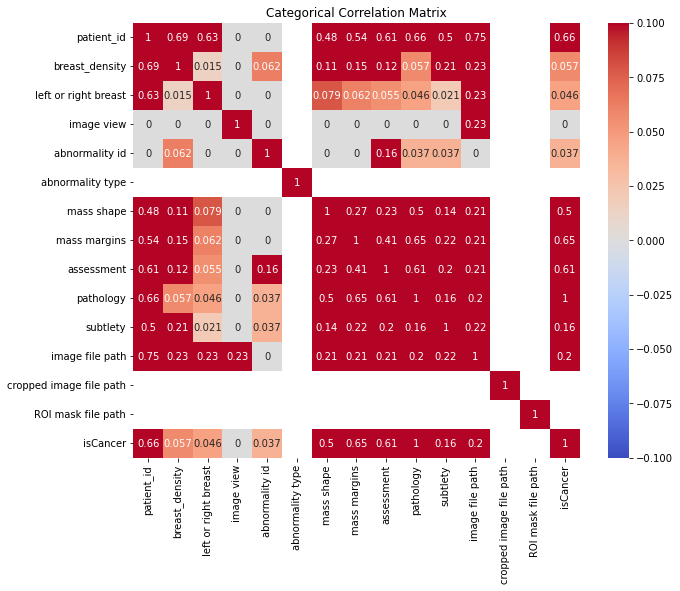

In [5]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def categorical_correlation_matrix(df):
    cols = df.columns
    n_cols = len(cols)
    corr_matrix = np.zeros((n_cols, n_cols))
    for i in range(n_cols):
        for j in range(n_cols):
            if i == j:
                corr_matrix[i, j] = 1
            else:
                corr = cramers_v(df[cols[i]], df[cols[j]])
                corr_matrix[i, j] = corr
                corr_matrix[j, i] = corr
    return pd.DataFrame(corr_matrix, index=cols, columns=cols)

corr_matrix = categorical_correlation_matrix(df)

# Plot the correlation matrix using Seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Categorical Correlation Matrix')
plt.show()

In [6]:
# Remove any fields that would not compute within the matrix above

# There are repeated image data, so we must remove that field as well. 
# It makes sense why there is a correlation, but it is still nonsensical.

df = df.drop(columns=['patient_id', 'image view', 'abnormality type', 'pathology', 'image file path', 'cropped image file path', 'ROI mask file path'])
df

,breast_density,left or right breast,abnormality id,mass shape,mass margins,assessment,subtlety,isCancer
0,4,LEFT,1,IRREGULAR,SPICULATED,5,5,True
1,4,LEFT,1,IRREGULAR,SPICULATED,5,5,True
2,2,LEFT,1,ROUND,CIRCUMSCRIBED,4,4,True
3,2,LEFT,1,ROUND,ILL_DEFINED,4,4,True
4,3,RIGHT,1,ROUND,OBSCURED,0,2,False
...,...,...,...,...,...,...,...,...
1691,2,RIGHT,1,IRREGULAR,ILL_DEFINED,3,4,True
1692,2,RIGHT,1,ROUND,SPICULATED,3,5,True
1693,2,RIGHT,1,ROUND,SPICULATED,3,5,True
1694,2,LEFT,1,IRREGULAR,SPICULATED,3,2,True


One-hot encode categorical variables

In [7]:
encoded_df = pd.get_dummies(df, columns=['left or right breast', 'mass shape', 'mass margins'])
encoded_df

,breast_density,abnormality id,assessment,subtlety,isCancer,left or right breast_LEFT,left or right breast_RIGHT,mass shape_ARCHITECTURAL_DISTORTION,mass shape_ASYMMETRIC_BREAST_TISSUE,mass shape_FOCAL_ASYMMETRIC_DENSITY,...,mass margins_MICROLOBULATED,mass margins_MICROLOBULATED-ILL_DEFINED,mass margins_MICROLOBULATED-ILL_DEFINED-SPICULATED,mass margins_MICROLOBULATED-SPICULATED,mass margins_OBSCURED,mass margins_OBSCURED-CIRCUMSCRIBED,mass margins_OBSCURED-ILL_DEFINED,mass margins_OBSCURED-ILL_DEFINED-SPICULATED,mass margins_OBSCURED-SPICULATED,mass margins_SPICULATED
0,4,1,5,5,True,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,4,1,5,5,True,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,1,4,4,True,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1,4,4,True,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,1,0,2,False,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,2,1,3,4,True,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1692,2,1,3,5,True,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1693,2,1,3,5,True,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1694,2,1,3,2,True,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Building the Classifier Models

In [8]:
TEST_SIZE = 0.25
RANDOM_STATE = 42
MAX_DEPTH = 9

In [9]:
def show_results(y_test, y_pred):
  print('accuracy score: ' + str(accuracy_score(y_test, y_pred)))
  con_matrix = confusion_matrix(y_test, y_pred)
  confusion_matrix_df = pd.DataFrame(con_matrix, ('Reject', 'Accept'), ('Reject', 'Accept'))
  heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
  plt.ylabel('Actual', fontsize = 14)
  plt.xlabel('Predicted', fontsize = 14)
  # Print the classification report
  print(classification_report(y_test, y_pred))
  plt.show()

In [10]:
def build_tree(df):
    y = df.isCancer
    X = df.drop(columns=['isCancer'])
    column_names = X.columns
    X = pd.DataFrame(np.nan_to_num(X.astype(np.float32)))
    X.columns = column_names.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)
    decision_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    show_results(y_test, y_pred)

In [11]:
def build_forest(df, estimators=100, max_depth=MAX_DEPTH):
    y = df.isCancer
    X = df.drop(columns=['isCancer'])
    column_names = X.columns
    X = pd.DataFrame(np.nan_to_num(X.astype(np.float32)))
    X.columns = column_names.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)
    forest = RandomForestClassifier(max_features=None, n_estimators=estimators, max_depth=max_depth, random_state=RANDOM_STATE)
    forest.fit(X_train, y_train)  
    y_pred = forest.predict(X_test)
    show_results(y_test, y_pred)
    return forest, X_train, X_test, y_train, y_test

In [12]:
def xgboost_classifier(df):
    y = df.isCancer
    X = df.drop(columns=['isCancer'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    # Define XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': 0.1,
        'max_depth': MAX_DEPTH,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': RANDOM_STATE
    }

    dtrain = xgb.DMatrix(data=X_train, label=y_train)
    dtest = xgb.DMatrix(data=X_test, label=y_test)
    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=100)
    y_pred_proba = model.predict(dtest)
    y_pred = (y_pred_proba > 0.5).astype(int)
    show_results(y_test, y_pred)

## Evaluating Model Results

accuracy score: 0.8277634961439588
              precision    recall  f1-score   support

       False       0.81      0.85      0.83       193
        True       0.84      0.81      0.83       196

    accuracy                           0.83       389
   macro avg       0.83      0.83      0.83       389
weighted avg       0.83      0.83      0.83       389



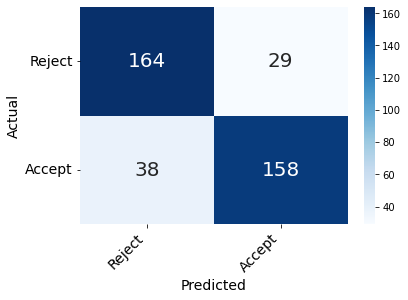

In [13]:
# Decision Tree
build_tree(encoded_df)

accuracy score: 0.8431876606683805
              precision    recall  f1-score   support

       False       0.82      0.87      0.85       193
        True       0.86      0.82      0.84       196

    accuracy                           0.84       389
   macro avg       0.84      0.84      0.84       389
weighted avg       0.84      0.84      0.84       389



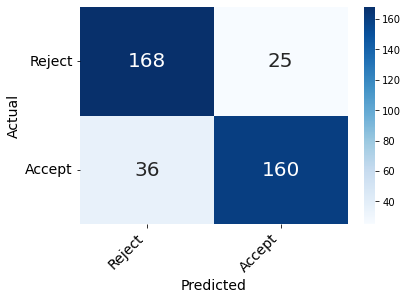

In [14]:
# Random Forest
forest, X_train, X_test, y_train, y_test = build_forest(encoded_df)

accuracy score: 0.8586118251928021
              precision    recall  f1-score   support

       False       0.84      0.89      0.86       194
        True       0.88      0.83      0.85       195

    accuracy                           0.86       389
   macro avg       0.86      0.86      0.86       389
weighted avg       0.86      0.86      0.86       389



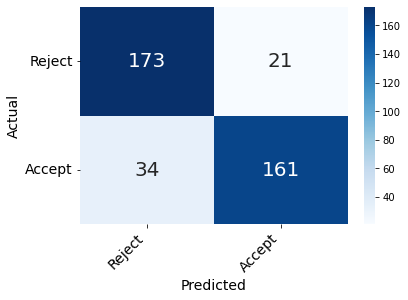

In [15]:
# XGBoost
xgboost_classifier(encoded_df)